# Time-series inversion with weights

Optionally, weights can be added to the inversion in favor of more reliable measurements. Here, it is essential to pick a robust quality indicator which may vary depending on the study target. This notebook will show how to incorporate weights into the inversion process and how to calculate network misclosure which can well identify outliers in a network with generally low noise levels or normally distributed errors. Examples are again based on a synthetic displacement signal with regular sampling and measurement errors. 

In [1]:
# load neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from itertools import combinations
import random

#import functions for time-series inversion from relevant python script
import timeseries_inversion as inv

#create an artificial displacement signal (analog to previous notebook)
start_date = datetime.strptime('01/01/2019', '%d/%m/%Y')
end_date = datetime.strptime('31/12/2023', '%d/%m/%Y')

dr = pd.date_range(start=start_date, end=end_date, freq='D')

#create synthetic cumulative displacement original_signal
#here: sigmoid + linear function
x = np.arange(0, len(dr), 1)
y = 0.01 * x + 20 / (1 + np.exp(-0.02 * (np.arange(len(dr)) - len(dr)/2)))
original_signal = pd.DataFrame({'date': dr, 'disp': y})

#create sample dates, here with a 3 month spacing
sample_dates = pd.date_range(start=start_date, end=end_date, freq='3MS')

#create image pairs from sample dates
date_combinations = list(combinations(sample_dates, 2))

network = pd.DataFrame(date_combinations, columns=['date0', 'date1'])

#find displacement for each datepair according to the synthetic signal
network['disp'] = network.apply(lambda row: inv.find_dsoll(row, original_signal), axis = 1)

#simulate measurement error
np.random.seed(123)
error = np.random.normal(0,5,len(network))

network["disp"] = network["disp"] + error

One parameter that has been suggested as a weighting factor is the time difference (dt) between reference and secondary image, either in favor of short temporal baselines (e.g., Lacroix et al., 2019) or longer temporal baselines (e.g., [Provost et al., 2022](https://doi.org/10.1016/j.rse.2022.112949)). In the following, we calculate the temporal baseline of image pairs in the network and convert it into weights that can be supplied to the inversion. 

Number of image pairs: 190
Number of groups in network: 1
Number of image pairs: 190
Number of groups in network: 1


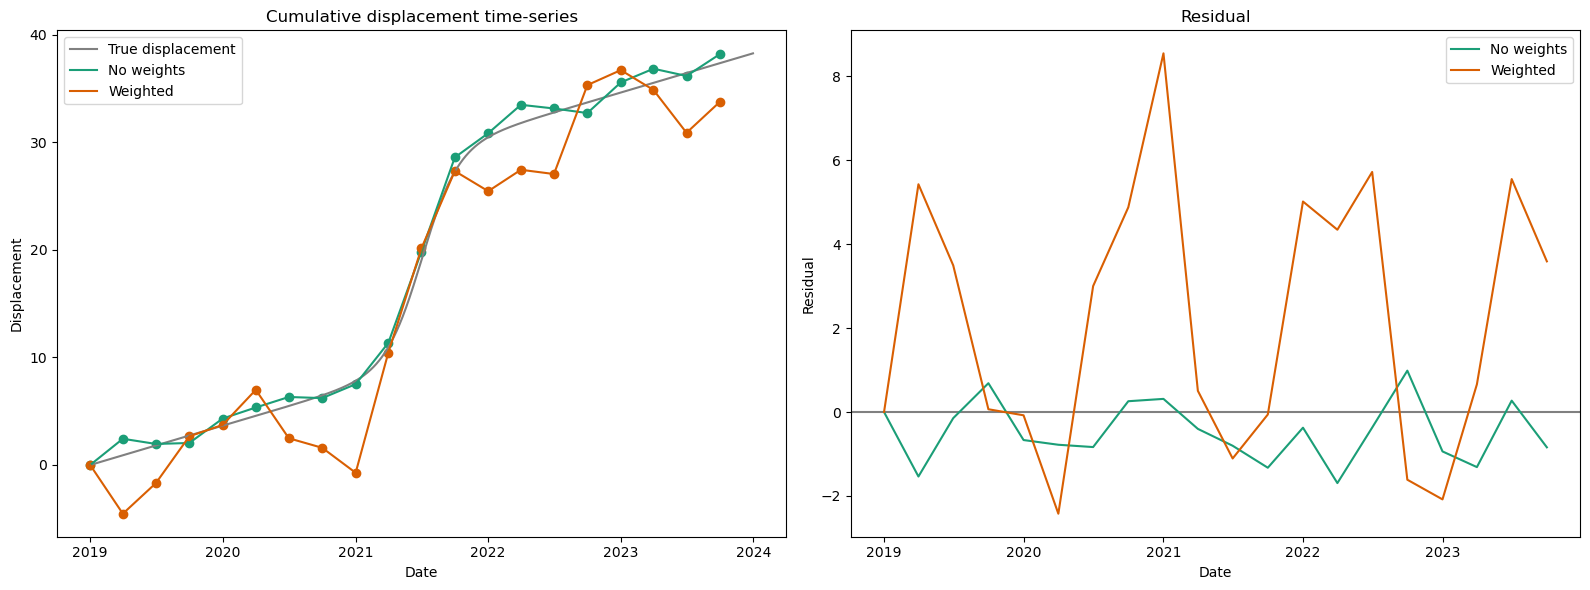

In [2]:
# calculate dt in days
network["dt"] = (network.date1 - network.date0).dt.days

# calculate weights for dt favoring a long temporal baseline (see Provost et al., 2022)
network["weights"] = 1/(1 + (network["dt"].max() - network["dt"]))
# alternative: calculate weights in favor of short temporal baseline (see Provost et al., 2022)
network["weights"] = 1/(1 + (network["dt"] - network["dt"].min()))

# run inversion with and without weights and compare results
ts_noweight = inv.run_inversion(network)
ts_weight = inv.run_inversion(network, weightcol = "weights")
inv.plot_timeseries([ts_noweight, ts_weight], original_signal, legend = ["No weights", "Weighted"])

We can see that the weighting by the temporal baseline has not done any good with regards of the reconstruction accuracy of the inverted time series. That is because the assigned weights do not scale with the random Gaussian measurement error assigned to the correlation pairs:

Text(0, 0.5, 'Weight')

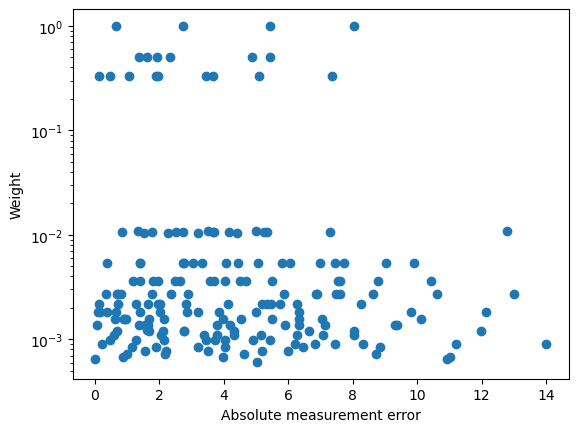

In [3]:
fig, ax = plt.subplots(1,1)
ax.scatter(abs(error), network.weights)
ax.set_yscale('log')
ax.set_xlabel("Absolute measurement error")
ax.set_ylabel("Weight")

Therefore, it is important to know the data and the conditions at the study site well to pick an appropriate weighting factor. Else, it is probably best to run the inversion without weights to avoid overweighting erroneous displacement measurements. After an initial unweighted inversion, it has been suggested to use the network misclosure, i.e. the residual between estimated pairwise displacement and the displacement accumulated between
two dates according to the inverted time series retrieved for the full network. In the following, we will calculate this residual and use it to re-weigh measurements in a second inversion process.

Number of image pairs: 190
Number of groups in network: 1
Number of image pairs: 190
Number of groups in network: 1


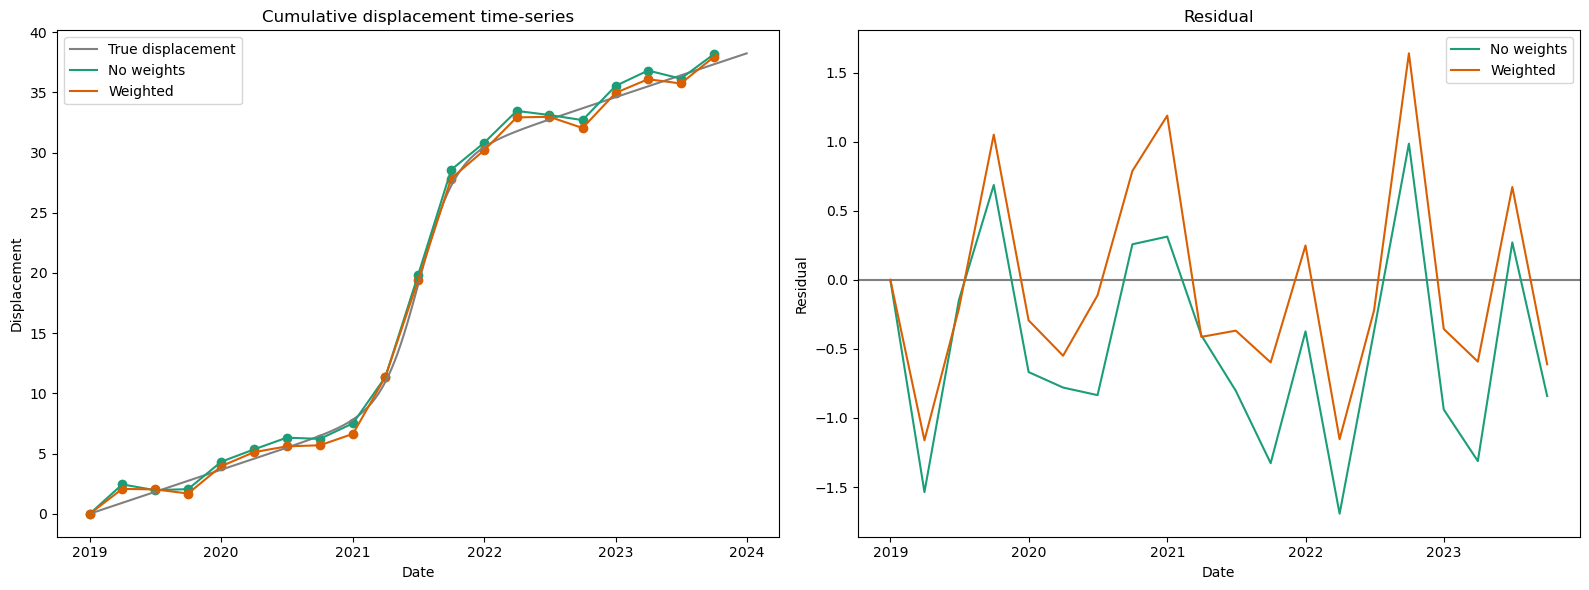

In [4]:
# run find_dsoll but with the first inversion as reference
network["disp_inv1"] = network.apply(lambda row: inv.find_dsoll(row, ts_noweight, dispcol = "disp_inversion"), axis = 1)

#calculate residual
network["misclosure"] = network.disp - network.disp_inv1

#turn into weights 
#first take absolute value and scale between 0 and 1
network["weights"] = inv.min_max_scaler(abs(network.misclosure))

#take 1 over the misclosure to favor measurements with a smaller residual
network["weights"] = 1/(1+network.weights)**2

#rerun the inversion and compare
ts_noweight = inv.run_inversion(network)
ts_weight = inv.run_inversion(network, weightcol = "weights")
inv.plot_timeseries([ts_noweight, ts_weight], original_signal, legend = ["No weights", "Weighted"])

Through re-running the inversion weighted by network misclosure, the residuals between inverted time series and original displacement signal are a little more zero centered. This improvement results from the fact that in this case, the assigned weights reflect the measurement errors well:  

Text(0, 0.5, 'Weight')

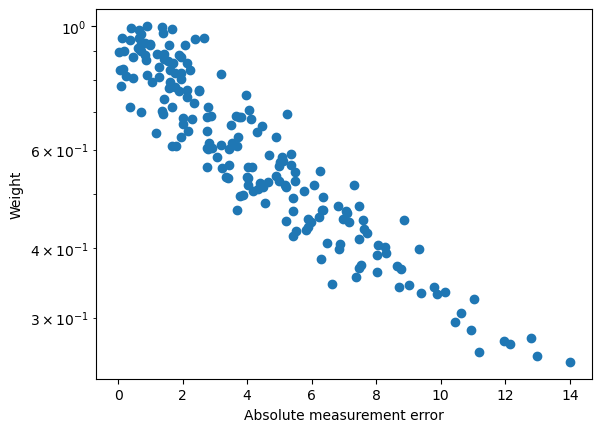

In [5]:
fig, ax = plt.subplots(1,1)
ax.scatter(abs(error), network.weights)
ax.set_yscale('log')
ax.set_xlabel("Absolute measurement error")
ax.set_ylabel("Weight")